# LeNet-5 on HODA

## Silence TensorFlow
We can control the verbosity of TF by setting the `TF_CPP_MIN_LOG_LEVEL` environment variable _before_ importing TensorFlow.

This step is enitrely __optional__. But TensorFlow's useless log messages can get annoying...

In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## Imports

In [4]:
import logging

import keras
from keras import layers, optimizers, utils, callbacks

import matplotlib.pyplot as plt

from numa.dataset import hoda


## Settings

In [5]:
# Set logging level to info (used in some parts of this project)
logging.basicConfig(level=logging.INFO)

# Learning rate for Gradient descent
LEARNING_RATE = 0.01
# Number of iterations for training model
EPOCHS = 30
# Number of samples utilized in one training iteration (Usually 128 or 256 is a good choice for GPU)
BATCH_SIZE = 256


## Importing dataset
This step may take a long time to complete. This is due to the fact that the HODA database is __not__ using format compatible with TF, therefore the dataset must be converted before getting fed into the model. 

In [6]:
# 32x32 binary datasets
(train_images, train_labels), (test_images,
                               test_labels) = hoda.load_dataset(32)


INFO:root:Reading dataset /home/mehrzad/Code/numa/numa/dataset/hoda/Train.cdb
INFO:root:Release date: 2005/8/4
INFO:root:Records: 60000
INFO:root:Reading dataset /home/mehrzad/Code/numa/numa/dataset/hoda/Test.cdb
INFO:root:Release date: 2005/8/4
INFO:root:Records: 20000


## Preparing dataset
We have to do some preparations on the dataset before feeding it to the model, more specifically we need to normalize the dataset images and convert labels to one-hot labels

In [7]:
# Normalize
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# One-hot labels
train_labels = utils.to_categorical(train_labels)
test_labels = utils.to_categorical(test_labels)


## Model
Model configuration:
  * Using Gradient descent as the optimizer
  * Using 'Categorical crossentropy' as loss function
    * Model weights are adjusted in a way to minimize the cross-entropy loss (the smaller the loss the better the model)
  * Using 'accuracy' as metric (how often predictions match actual labels)
  * Most of the time kernel size of 3x3 or 5x5 works the best

In [8]:
# Define model
model = keras.Sequential([
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu',
                  padding='same', input_shape=(32, 32, 1)),  # C1
    layers.MaxPooling2D(pool_size=(2, 2)),  # S2
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),  # C3
    layers.MaxPooling2D(pool_size=(2, 2)),  # S4
    layers.Flatten(),
    layers.Dense(120, activation='relu'),  # C5
    layers.Dense(84, activation='relu'),  # F6
    layers.Dense(10, activation='softmax'),  # Output
])

# Configure model
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 120)               9

## Training model
This is where the real fun begins! The model defined in the previous cell will get trained by the HODA dataset.

This step will take a _long_ time. Go grab a cup of coffee. 

* How are we supposed to choose the value for `steps_per_epoch` and `validation_steps` fields?

  Most of the time `(number of samples / batch size)` will have good results.

  In our case `number of samples` is the first field of the dataset array shape.

  (Dataset array shape: `(60000, 32, 32)` - that is 60000 images of size 32x32)

In [9]:
# Interrupt training if `val_loss` hasn't decreased in 10 epochs
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_images, train_labels,
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    steps_per_epoch=train_images.shape[0] // BATCH_SIZE,
                    validation_data=(test_images, test_labels),
                    validation_steps=test_images.shape[0] // BATCH_SIZE,
                    callbacks=[early_stop], verbose=1)  # type: ignore

# For some weird reason VSCode gets hung up on the verbose=1 argument type, hence the '#type: ignore' comment


Epoch 1/30
234/234 [==============================] - 16s 20ms/step - loss: 1.5619 - accuracy: 0.5033 - val_loss: 0.5618 - val_accuracy: 0.8042
Epoch 2/30
234/234 [==============================] - 4s 17ms/step - loss: 0.2241 - accuracy: 0.9333 - val_loss: 0.3474 - val_accuracy: 0.8831
Epoch 3/30
234/234 [==============================] - 4s 18ms/step - loss: 0.1524 - accuracy: 0.9547 - val_loss: 0.2651 - val_accuracy: 0.9174
Epoch 4/30
234/234 [==============================] - 4s 17ms/step - loss: 0.1304 - accuracy: 0.9615 - val_loss: 0.2413 - val_accuracy: 0.9234
Epoch 5/30
234/234 [==============================] - 4s 17ms/step - loss: 0.1123 - accuracy: 0.9668 - val_loss: 0.2175 - val_accuracy: 0.9306
Epoch 6/30
234/234 [==============================] - 4s 18ms/step - loss: 0.1013 - accuracy: 0.9700 - val_loss: 0.1929 - val_accuracy: 0.9415
Epoch 7/30
234/234 [==============================] - 4s 18ms/step - loss: 0.0917 - accuracy: 0.9724 - val_loss: 0.1786 - val_accuracy: 0.945

## Evaluating model

In [10]:
_, accuracy = model.evaluate(
    test_images, test_labels, verbose=1)  # type: ignore
print(f"Model accuracy: {accuracy * 100:.2f}%")


625/625 [==============================] - 6s 10ms/step - loss: 0.0893 - accuracy: 0.9722
Model accuracy: 97.22%


## Visualization
Let's see a fancy visualization of the model accuracy, shall we?

The `history` object returned after training the model contains the metrics which we can access just like a `dict`.

In our case, the history object contains the following metrics: `loss`, `accuracy`, `val_loss`, `val_accuracy`

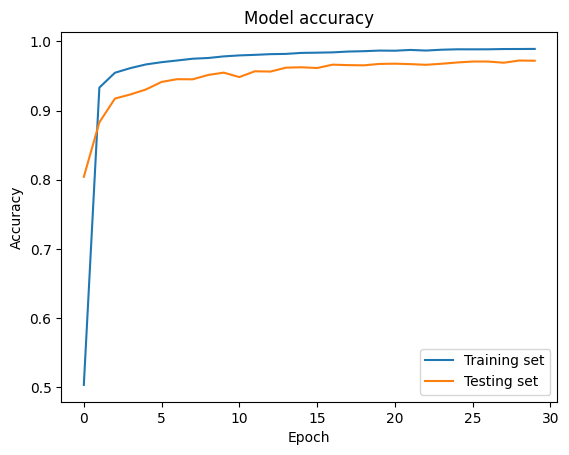

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training set', 'Testing set'], loc='lower right')

plt.show()
